<a href="https://colab.research.google.com/github/RavindraTanniru/Ravindra_DataScience/blob/main/Oceanic_Pollution_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
# Import StratifiedKFold from sklearn.model_selection
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight


In [ ]:
# Constants
bs = 16
crop_size = 128
channels = 3
EPOCHS = 20
K_FOLDS = 5
learning_rate = 1e-3


In [ ]:
# Load the dataset (assuming it's already unzipped and ready)
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"/content/drive/MyDrive/Oceanic_Final_DS/Data",  # Path to your dataset
    labels='inferred',
    shuffle=True,
    image_size=(crop_size, crop_size),  # Resize to (128, 128)
    batch_size=bs
)

Found 1494 files belonging to 4 classes.


In [ ]:
# Class names
class_names = dataset.class_names
print("Class names:", class_names)

# Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2)
])


Class names: ['OilSpill', 'Other_Waste', 'Plastic', 'non_polluted']


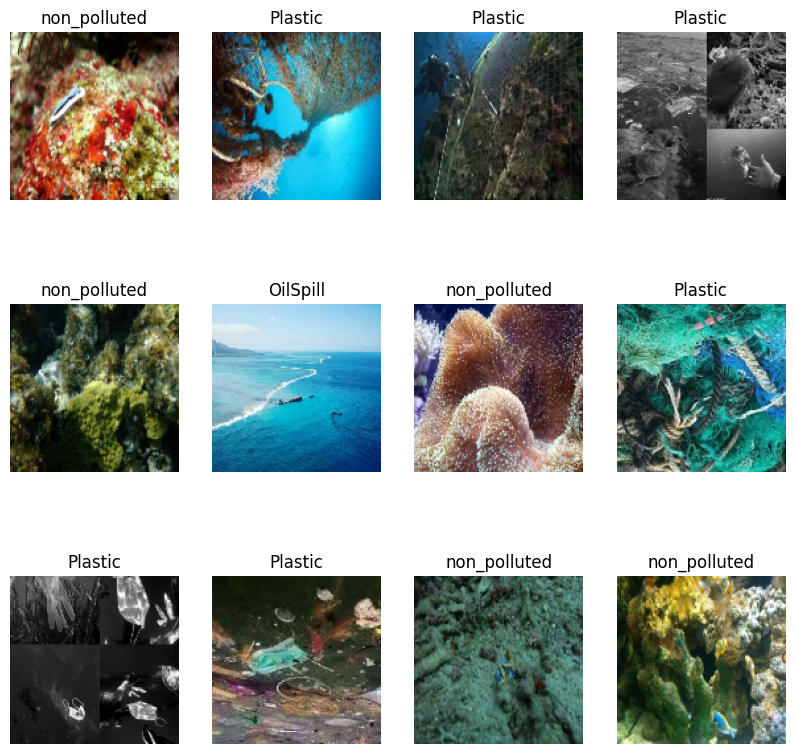

In [ ]:
# Visualize some images
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")


In [ ]:
# Preprocessing function to normalize pixel values (0-255) to (0-1)
def preprocess_data(images, labels):
    return images / 255.0, labels

# Apply preprocessing to the dataset
dataset = dataset.map(preprocess_data)

# Convert dataset to NumPy arrays for Stratified K-Fold
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for image_batch, label_batch in dataset:
        images.append(image_batch)
        labels.append(label_batch)
    return np.concatenate(images), np.concatenate(labels)

# Convert dataset to NumPy arrays for splitting
image_array, label_array = dataset_to_numpy(dataset)


In [ ]:
# Install EfficientNet
!pip install efficientnet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.0 MB/s eta 0:00:00


In [ ]:
# Import EfficientNet
from efficientnet.tfkeras import EfficientNetB0

# Feature Pyramid Network (FPN) for multi-scale feature extraction
def build_fpn(base_model):
    # Extract feature maps from different levels of EfficientNetB0
    f3 = base_model.get_layer('block3a_expand_activation').output  # Low-level features
    f4 = base_model.get_layer('block4a_expand_activation').output  # Mid-level features
    f6 = base_model.get_layer('block6a_expand_activation').output  # High-level features
    f8 = base_model.get_layer('top_activation').output  # Highest-level features

    # Apply 1x1 convolutions to reduce channel dimensions
    f3 = layers.Conv2D(256, (1, 1), padding='same', activation='relu')(f3)
    f4 = layers.Conv2D(256, (1, 1), padding='same', activation='relu')(f4)
    f6 = layers.Conv2D(256, (1, 1), padding='same', activation='relu')(f6)
    f8 = layers.Conv2D(256, (1, 1), padding='same', activation='relu')(f8)

    # Upsample and merge feature maps
    f8_upsampled = layers.UpSampling2D(size=(2, 2))(f8)
    f6 = layers.Add()([f6, f8_upsampled])

    f6_upsampled = layers.UpSampling2D(size=(2, 2))(f6)
    f4 = layers.Add()([f4, f6_upsampled])

    f4_upsampled = layers.UpSampling2D(size=(2, 2))(f4)
    f3 = layers.Add()([f3, f4_upsampled])

    return f3

# Create model with FPN and dilated convolutions
def create_model(input_shape=(crop_size, crop_size, channels), n_classes=len(class_names), learning_rate=1e-3):
    # Load EfficientNetB0 as base model
    base_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the pre-trained model initially

    # Build FPN
    fpn_output = build_fpn(base_model)

    # Add dilated convolutions
    x = layers.Conv2D(256, (3, 3), dilation_rate=(2, 2), padding='same', activation='relu')(fpn_output)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), dilation_rate=(4, 4), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Global pooling and dense layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output layer for classification
    outputs = layers.Dense(n_classes, activation='softmax')(x)

    # Create the final model
    model = models.Model(inputs=base_model.input, outputs=outputs)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


Training fold 1/5...

16804768/16804768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 58s 372ms/step - accuracy: 0.7692 - loss: 0.7292 - val_accuracy: 0.9164 - val_loss: 0.2769 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - accuracy: 0.8772 - loss: 0.3194 - val_accuracy: 0.7793 - val_loss: 1.4243 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9264 - loss: 0.1639 - val_accuracy: 0.9599 - val_loss: 0.1486 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9621 - loss: 0.3065 - val_accuracy: 0.9766 - val_loss: 0.0905 - learning_rate: 0.0010
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9706 - loss: 0.0515 - val_accuracy: 0.9666 - val_loss: 0.1175 - learning_rate: 0.0010
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9904 - loss: 0.0371 - val_accuracy: 0.1706 - val_loss: 22.1991 - learning_rate: 0.0010
Epoch 7/20
74/75

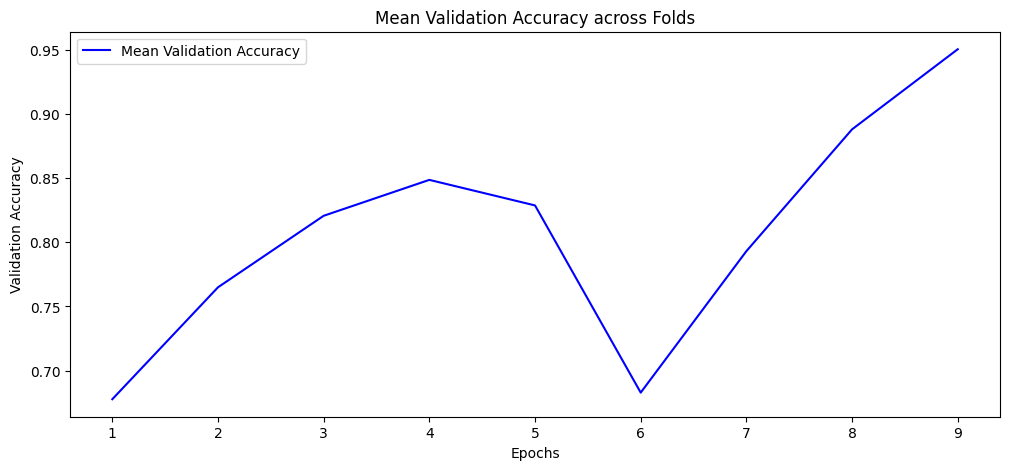

In [ ]:
# K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

# Lists to store accuracy and loss for each fold
fold_accuracies = []
fold_losses = []
fold_histories = []

# Cross-validation training
for fold, (train_index, test_index) in enumerate(kf.split(image_array, label_array)):
    print(f"\nTraining fold {fold+1}/{K_FOLDS}...\n")

    # Get training and testing splits for the current fold
    train_images, test_images = image_array[train_index], image_array[test_index]
    train_labels, test_labels = label_array[train_index], label_array[test_index]

    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(bs)
    test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(bs)

    # Handle class imbalance by calculating class weights
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weights = {i: class_weights[i] for i in range(len(class_names))}

    # Create a new model for each fold
    model = create_model()

    # Callbacks: EarlyStopping and ReduceLROnPlateau for adaptive learning rate
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True
    )

    lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6
    )

    # Train the model on the current fold
    history = model.fit(
        train_ds,
        epochs=EPOCHS,
        validation_data=test_ds,
        class_weight=class_weights,  # Apply class weights to handle imbalance
        callbacks=[early_stopping, lr_schedule]
    )

    # Store accuracy and loss for each fold
    fold_histories.append(history.history)
    fold_accuracies.append(history.history['val_accuracy'])
    fold_losses.append(history.history['val_loss'])

# Plot average validation accuracy and loss across folds
min_epochs = min(len(fold_accuracy) for fold_accuracy in fold_accuracies)
mean_val_accuracy = np.mean([fold_accuracy[:min_epochs] for fold_accuracy in fold_accuracies], axis=0)
mean_val_loss = np.mean([fold_loss[:min_epochs] for fold_loss in fold_losses], axis=0)

# Plot mean validation accuracy
plt.figure(figsize=(12, 5))
epochs = range(1, min_epochs + 1)
plt.plot(epochs, mean_val_accuracy, label='Mean Validation Accuracy', color='b')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Mean Validation Accuracy across Folds')
plt.legend()
plt.show()

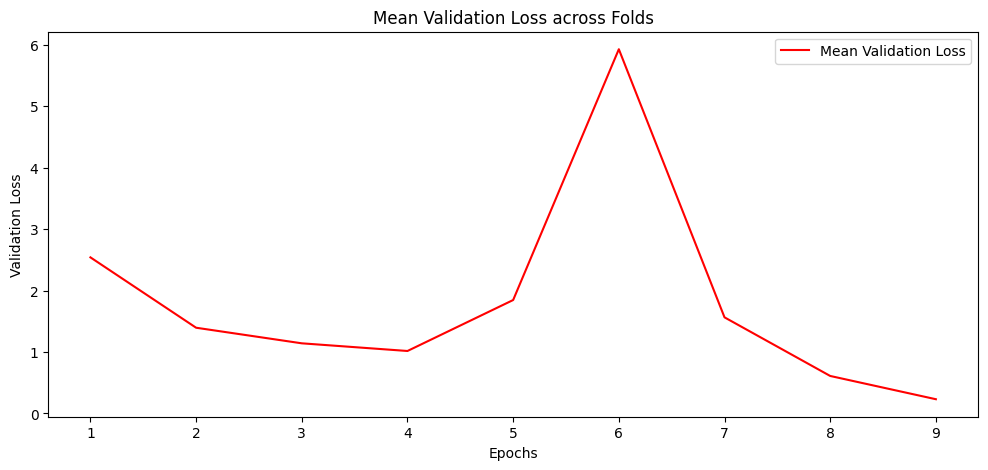

In [ ]:
# Plot mean validation loss
plt.figure(figsize=(12, 5))
plt.plot(epochs, mean_val_loss, label='Mean Validation Loss', color='r')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Mean Validation Loss across Folds')
plt.legend()
plt.show()

In [ ]:
# Final model evaluation
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
print(f"Final Training Accuracy: {train_accuracy[-1] * 100:.2f}%")
print(f"Final Validation Accuracy: {val_accuracy[-1] * 100:.2f}%")


Final Training Accuracy: 98.75%
Final Validation Accuracy: 95.64%


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


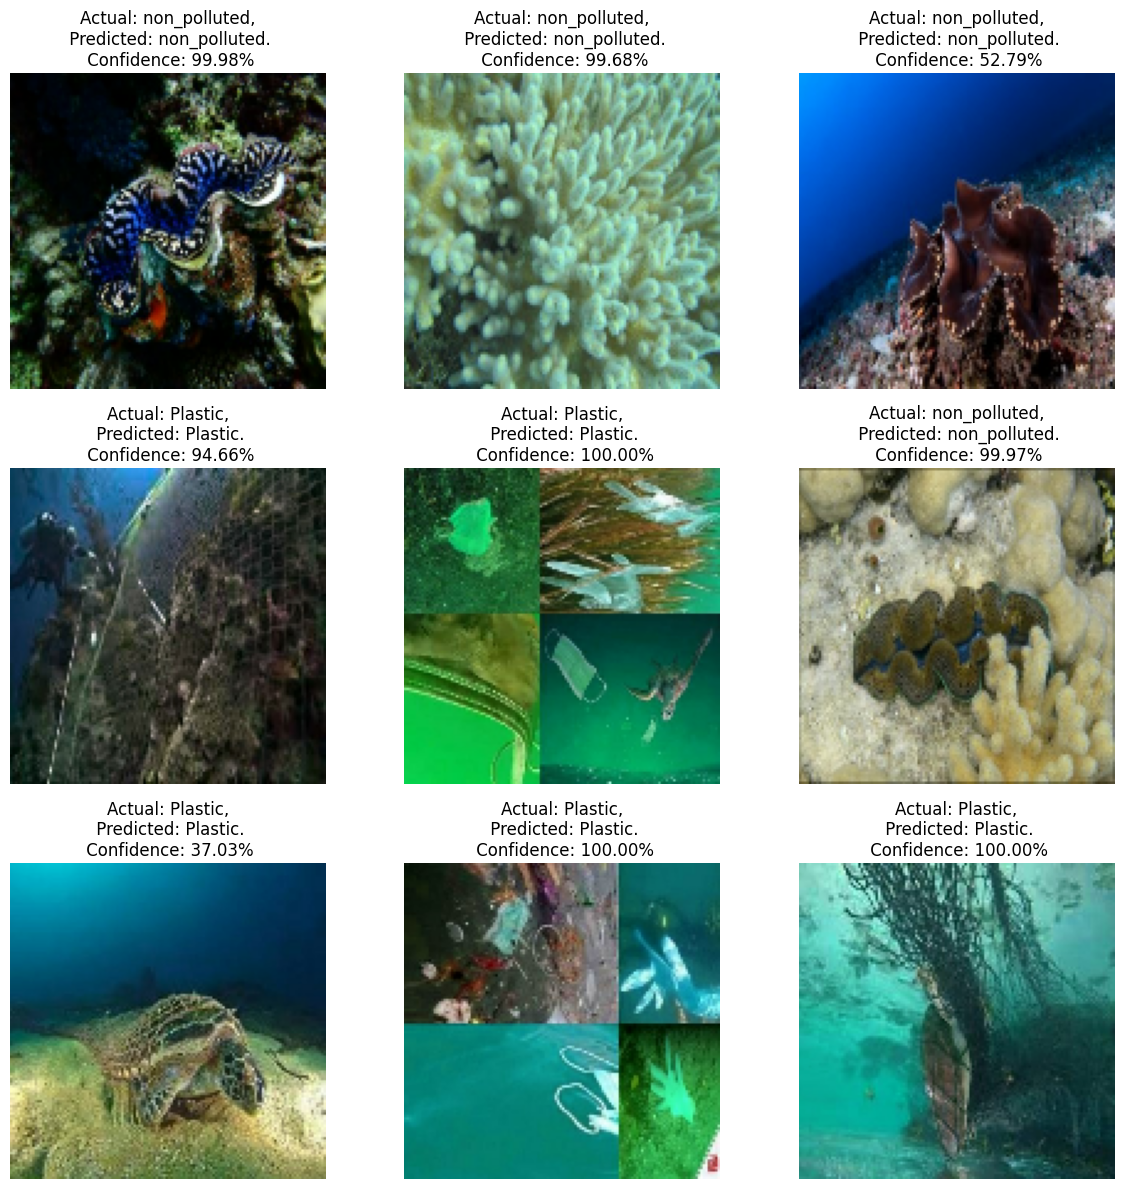

In [ ]:
# Final model prediction function
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch dimension
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

# Example visualization (Predicted vs Actual labels)
for images, labels in test_ds.take(1):  # Taking a batch for visualization
    plt.figure(figsize=(12, 12))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        # Convert image to uint8 and denormalize if necessary
        img = images[i].numpy()

        # Check if images were normalized between [0, 1]
        if img.max() <= 1.0:  # Normalize to [0, 255]
            img = (img * 255).astype("uint8")

        plt.imshow(img)
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence:.2f}%")
        plt.axis("off")

    plt.tight_layout()
    plt.show()